In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [2]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\DelhiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,01-01-2019 00:00,655.50,49.08,92.30,79.22,0.30,226.00,3.57,990.10,NaN,4.65
1,01-01-2019 01:00,583.50,52.18,62.35,79.70,0.30,197.25,3.62,990.05,NaN,4.58
2,01-01-2019 02:00,435.75,55.25,60.20,78.10,0.30,202.00,3.57,989.95,NaN,4.72
3,01-01-2019 03:00,351.50,51.48,52.07,77.48,0.30,197.75,3.65,989.98,NaN,4.43
4,01-01-2019 04:00,319.75,46.30,49.42,77.98,0.30,230.50,3.87,990.12,NaN,4.02
...,...,...,...,...,...,...,...,...,...,...,...
35059,31-12-2022 19:00,131.50,58.82,8.65,81.25,0.52,165.50,5.65,976.60,NaN,17.02
35060,31-12-2022 20:00,129.25,55.02,7.15,84.28,0.30,169.00,5.72,976.60,NaN,15.78
35061,31-12-2022 21:00,148.00,53.05,6.08,87.43,0.30,168.25,5.75,976.62,NaN,14.70
35062,31-12-2022 22:00,178.25,43.45,5.48,89.18,0.30,177.75,5.78,976.60,NaN,14.02


In [3]:
data = data.drop(columns=[ 'From Date'])

In [4]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [5]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [6]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [7]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [9]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [11]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100

877/877 [==============================] - 48s 27ms/step - loss: 13020.9639 - val_loss: 9369.6582
Epoch 2/100
877/877 [==============================] - 17s 19ms/step - loss: 8007.9365 - val_loss: 6226.3281
Epoch 3/100
877/877 [==============================] - 16s 18ms/step - loss: 5874.1543 - val_loss: 4973.7285
Epoch 4/100
877/877 [==============================] - 15s 18ms/step - loss: 4931.8413 - val_loss: 4376.5732
Epoch 5/100
877/877 [==============================] - 18s 21ms/step - loss: 4451.1182 - val_loss: 4036.7603
Epoch 6/100
877/877 [==============================] - 17s 19ms/step - loss: 4158.6504 - val_loss: 3823.2170
Epoch 7/100
877/877 [==============================] - 19s 21ms/step - loss: 3957.4536 - val_loss: 3651.3723
Epoch 8/100
877/877 [==============================] - 18s 20ms/step - loss: 3786.5117 - val_loss: 3504.5605
Epoch 9/100
877/877 [==============================] - 21s 23ms/step - loss: 3655.3926 - val_loss: 3444.6274
Epoch 10/100
877/

In [13]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

220/220 [==============================] - 3s 11ms/step - loss: 2321.7686
Test Loss: 2321.7685546875
220/220 [==============================] - 15s 10ms/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9385877318116975
Root Mean Square Error (RMSE): 48.18472433602449
Correlation Coefficient (r): 0.87191967737448
Mean Gross Error (MGE): 29.335371140350524
Mean Bias (MB): 2.1351469359989683
Coefficient of Efficiency (COE): 0.7597508922399036
Coefficient of Determination (R2 score): 0.7591271475849811


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = (np.maximum(y_true / y_pred, y_pred / y_true) <= 2)
    return np.mean(within_factor)

# Example y_test and predictions
# Replace these with your actual y_test and predictions arrays
y_test = np.random.rand(100) * 100
predictions = y_test + np.random.randn(100) * 10

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')



# # Scatter plot of actual vs. predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, predictions, alpha=0.7, edgecolors='b')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.show()

# # Line plot of actual and predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual Values', color='blue', linewidth=2)
# plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', linewidth=2)
# plt.title('Actual and Predicted Values Over Time')
# plt.xlabel('Time Span During the Years ')
# plt.ylabel('Frequency Fluctuation')
# plt.legend()
# plt.show()

# # Residuals vs. predicted values plot
# plt.figure(figsize=(10, 6))
# plt.scatter(predictions, residuals, alpha=0.7, edgecolors='b')
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
# plt.title('Residuals vs. Predicted Values')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.show()


Fraction of predictions with a factor of 2 (FAC2): 0.93
Root Mean Square Error (RMSE): 9.964349574271276
Correlation Coefficient (r): 0.9407961054012962
Mean Gross Error (MGE): 7.969342399025898
Mean Bias (MB): -0.5472275675688028
Coefficient of Efficiency (COE): 0.8823779456441937
Coefficient of Determination (R2 score): 0.8823779456441937


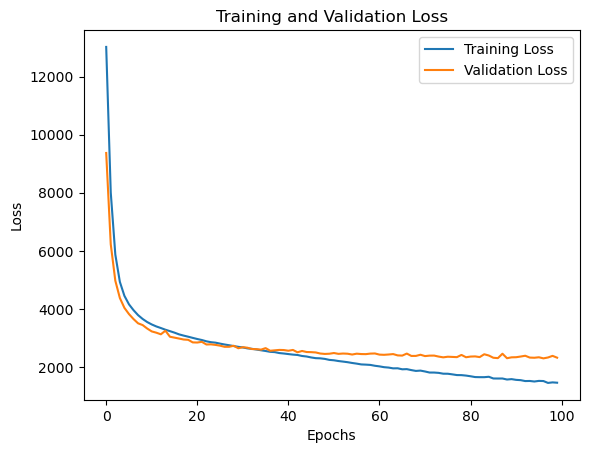

In [16]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\himan\AppData\Local\Temp\ipykernel_7896\1899136162.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


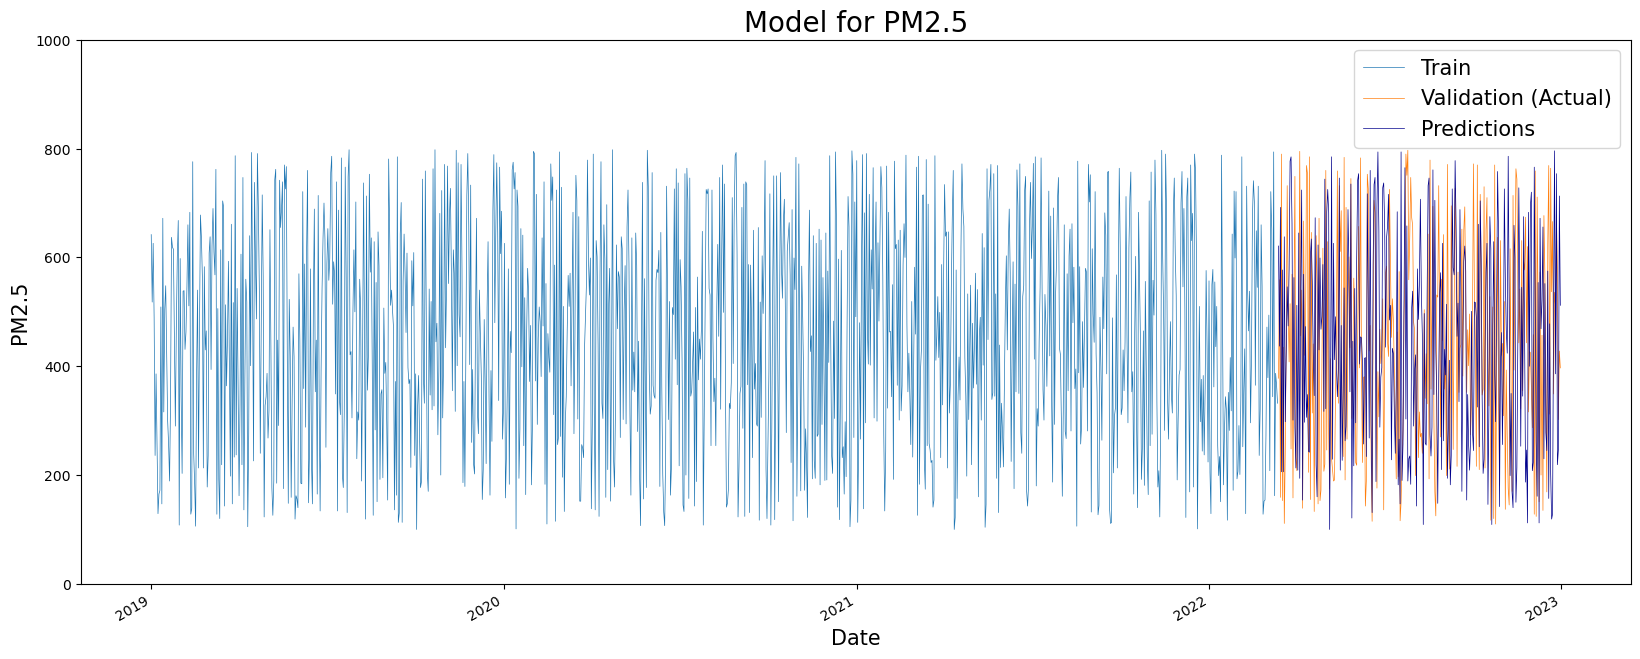

In [17]:
import pandas as pd
import matplotlib.dates as mdates

# Example DataFrame with dates from 2019 to 2024
date_range = pd.date_range(start='1/1/2019', end='31/12/2022')
df_date = pd.DataFrame({
    'Date': date_range,
    'PM2.5': np.random.randint(100, 800, size=len(date_range))
})
df_date.set_index('Date', inplace=True)

# Define the training data length
training_data_len = int(len(df_date) * 0.8)

# Split the data
train = df_date[:training_data_len]
valid = df_date[training_data_len:]

# Example predictions with the correct shape
predictions = np.random.randint(100, 800, size=len(valid))

# Add predictions to the validation set
valid["Predictions"] = predictions

# Plotting
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("PM2.5", fontsize=15)  # Updated y-axis label

# Plot with reduced line thickness
plt.plot(train.index, train['PM2.5'], label='Train', linewidth=0.5)
plt.plot(valid.index, valid['PM2.5'], label='Validation (Actual)', linewidth=0.5)
plt.plot(valid.index, valid["Predictions"], label='Predictions', linewidth=0.5, color='darkblue')

# Format the x-axis to show only the year
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Set y-axis limits
plt.ylim(0, 1000)

plt.legend(fontsize=15)
plt.show()

# END***